In [24]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
plt.style.use ('ggplot')
import geopandas as gpd
import folium as fl
from folium.features import GeoJson
from shapely.geometry import Point
from shapely.geometry import Polygon


In [2]:
data_distritos_csv = pd.read_csv('data/distritos_descentralizados_json.csv')
distritos = gpd.read_file('data/distritos_descentralizados.gml')

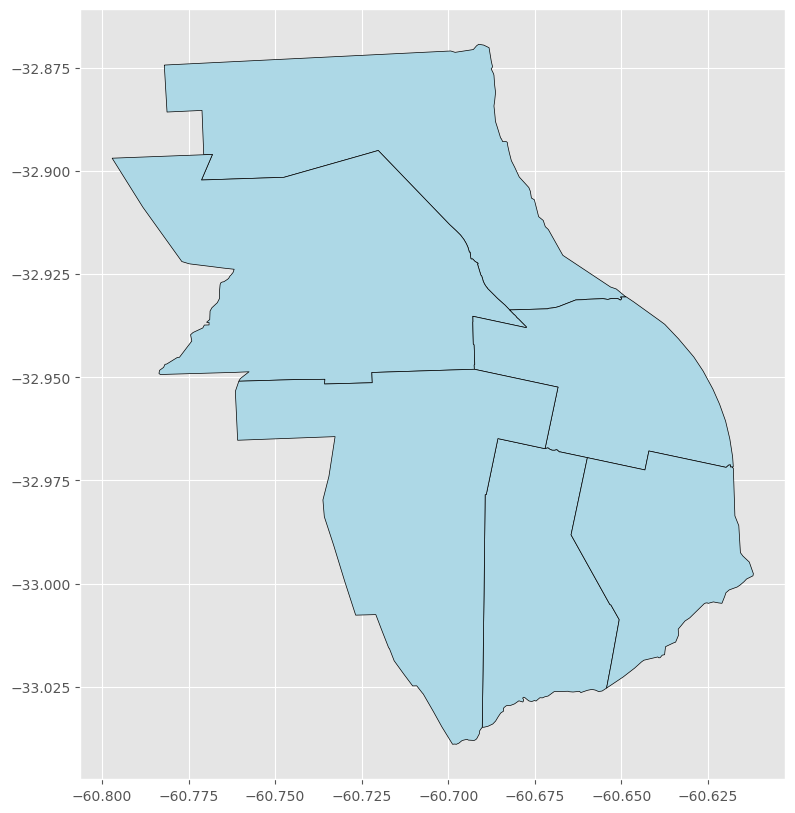

In [21]:
mapa_distritos = distritos.plot(color='lightblue', edgecolor='black', figsize=(10,10))
plt.show()

In [4]:
data = pd.read_excel('data/rosario f.xlsx')

In [5]:
from shapely.geometry import Point
from shapely.geometry import Polygon

In [6]:
data.columns

Index(['interview__key', 'METODO', 'Coord1__Latitude', 'Coord1__Longitude',
       'EDAD', 'GENERO', 'INT DE VOTO X ESPACIO', 'RADIO'],
      dtype='object')

In [7]:
#distritos y data. para ubicar encuestados en distritos
data['geometry'] = data.apply(lambda row: Point(row['Coord1__Longitude'], row['Coord1__Latitude']), axis=1)
data_geo = gpd.GeoDataFrame(data, geometry='geometry', crs="EPSG:4326")  # Ajusta el CRS si es necesario

# 3. Asegurarse de que ambos GeoDataFrames tengan el mismo CRS
if data_geo.crs != distritos.crs:
    data_geo = data_geo.to_crs(distritos.crs)

# 4. Realizar la unión espacial y crear el GeoDataFrame resultante llamado data_distritos
data_distritos = gpd.sjoin(data_geo, distritos, how="left", predicate="within")

# Verificar el resultado
print(data_distritos.head())

  interview__key METODO  Coord1__Latitude  Coord1__Longitude      EDAD  \
0    56-56-25-81    F2F        -32.881458         -60.695274  56 y mas   
1    67-96-98-06    F2F        -32.882259         -60.693571   36 a 45   
2    24-21-01-39    F2F        -32.884731         -60.692882  56 y mas   
3    84-96-80-81    F2F        -32.884673         -60.693464   26 a 35   
4    21-29-79-64    F2F        -32.918833         -60.703628   36 a 45   

      GENERO INT DE VOTO X ESPACIO      RADIO                     geometry  \
0  Masculino           LIBERTARIOS  820840409  POINT (-60.69527 -32.88146)   
1  Masculino                 OTROS  820840410  POINT (-60.69357 -32.88226)   
2   Femenino                 OTROS  820840502  POINT (-60.69288 -32.88473)   
3  Masculino           LIBERTARIOS  820840502  POINT (-60.69346 -32.88467)   
4   Femenino        NINGUNO/NOSABE  820841013  POINT (-60.70363 -32.91883)   

   index_right                        gml_id  DISTRITO  \
0          0.0  distritos_de

In [8]:
data_distr_df = data_distritos.drop(columns='geometry').copy()
data_distr_df.head()

,interview__key,METODO,Coord1__Latitude,Coord1__Longitude,EDAD,GENERO,INT DE VOTO X ESPACIO,RADIO,index_right,gml_id,DISTRITO,OBSERVACIO
0,56-56-25-81,F2F,-32.881458,-60.695274,56 y mas,Masculino,LIBERTARIOS,820840409,0.0,distritos_descentralizados.1,NORTE,Villa Hortencia
1,67-96-98-06,F2F,-32.882259,-60.693571,36 a 45,Masculino,OTROS,820840410,0.0,distritos_descentralizados.1,NORTE,Villa Hortencia
2,24-21-01-39,F2F,-32.884731,-60.692882,56 y mas,Femenino,OTROS,820840502,0.0,distritos_descentralizados.1,NORTE,Villa Hortencia
3,84-96-80-81,F2F,-32.884673,-60.693464,26 a 35,Masculino,LIBERTARIOS,820840502,0.0,distritos_descentralizados.1,NORTE,Villa Hortencia
4,21-29-79-64,F2F,-32.918833,-60.703628,36 a 45,Femenino,NINGUNO/NOSABE,820841013,1.0,distritos_descentralizados.2,NOROESTE,Olga y Leticia Cossettini


In [9]:
data_distr_df.columns = [name.lower() for name in data_distr_df.columns]
data_distr_df.head()
data_distr_df.rename(columns={'int de voto x espacio': 'intencion'}, inplace=True)
print(data_distr_df.columns)

Index(['interview__key', 'metodo', 'coord1__latitude', 'coord1__longitude',
       'edad', 'genero', 'intencion', 'radio', 'index_right', 'gml_id',
       'distrito', 'observacio'],
      dtype='object')


In [10]:
intencion_distrito = data_distr_df.groupby('distrito')['intencion'].value_counts().unstack(fill_value=0)
print(intencion_distrito)

intencion  FIT  FdT  JxC  LIBERTARIOS  NINGUNO/NOSABE  OTROS  PNK
distrito                                                         
CENTRO       7   24   30           18              25     10    3
NOROESTE     0   11   10            6              11      4    3
NORTE        2   10   12            7               7      4    4
OESTE        1   16   13           11              13      3    6
SUDOESTE     0    9    7            6               3      6    4
SUR          0    4    8            2               6      0    2


In [11]:
intencion_distrito['total'] = intencion_distrito.sum(axis=1)
print(intencion_distrito.head())


intencion  FIT  FdT  JxC  LIBERTARIOS  NINGUNO/NOSABE  OTROS  PNK  total
distrito                                                                
CENTRO       7   24   30           18              25     10    3    117
NOROESTE     0   11   10            6              11      4    3     45
NORTE        2   10   12            7               7      4    4     46
OESTE        1   16   13           11              13      3    6     63
SUDOESTE     0    9    7            6               3      6    4     35


In [12]:
#los NA de distrito son los 44 puntos que estan fuera de los poligonos de ROSARIO.
data_distr_df['distrito'].isna().value_counts()

distrito
False    328
True      44
Name: count, dtype: int64

PLOT PIE
#libertario por edad.
data[data['intencion_cat'] == 0]['edad'].value_counts().plot(kind='pie', autopct='%1.0f%%', figsize=(4,4))
plt.title('libertarios por edad')
plt.show()

PLOT BAR
data[data['metodo'] == 'F2F']['intencion'].value_counts().plot(kind='bar', figsize=(4,4))
plt.title('intencion en F2F')
plt.show()

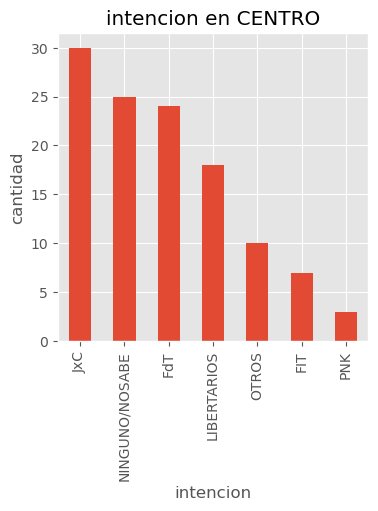

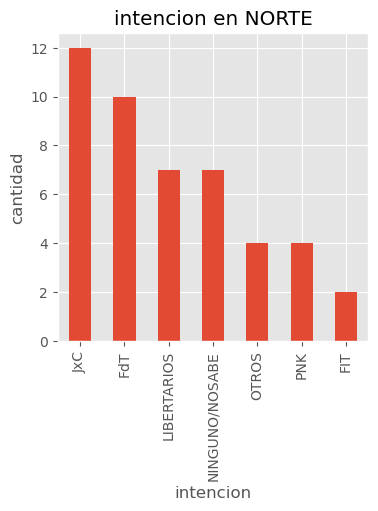

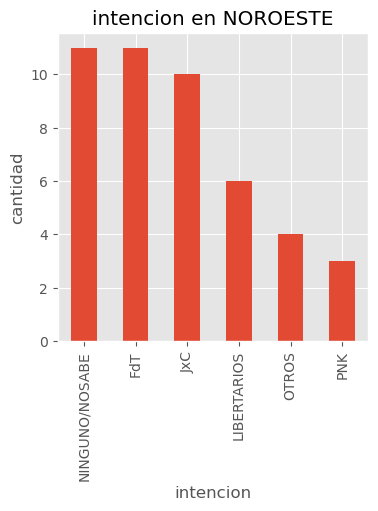

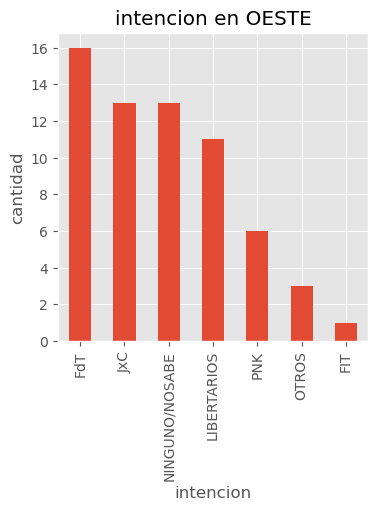

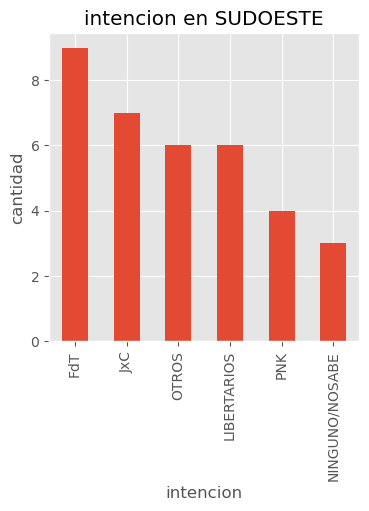

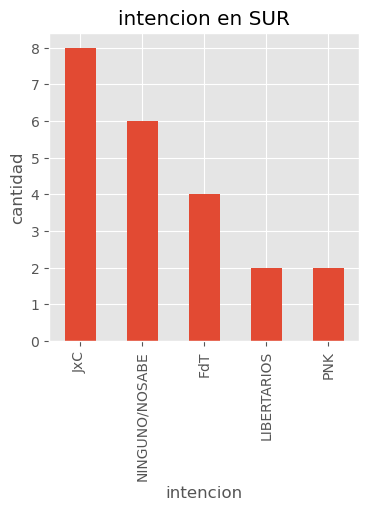

In [13]:
#bar distrito-intencion
data_distr_df[data_distr_df['distrito'] == 'CENTRO']['intencion'].value_counts().plot(kind='bar', figsize=(4,4))
plt.title('intencion en CENTRO')
plt.ylabel('cantidad')
plt.show()

data_distr_df[data_distr_df['distrito'] == 'NORTE']['intencion'].value_counts().plot(kind='bar', figsize=(4,4))
plt.title('intencion en NORTE')
plt.ylabel('cantidad')
plt.show()

data_distr_df[data_distr_df['distrito'] == 'NOROESTE']['intencion'].value_counts().plot(kind='bar', figsize=(4,4))
plt.title('intencion en NOROESTE')
plt.ylabel('cantidad')
plt.show()

data_distr_df[data_distr_df['distrito'] == 'OESTE']['intencion'].value_counts().plot(kind='bar', figsize=(4,4))
plt.title('intencion en OESTE')
plt.ylabel('cantidad')
plt.show()

data_distr_df[data_distr_df['distrito'] == 'SUDOESTE']['intencion'].value_counts().plot(kind='bar', figsize=(4,4))
plt.title('intencion en SUDOESTE')
plt.ylabel('cantidad')
plt.show()

data_distr_df[data_distr_df['distrito'] == 'SUR']['intencion'].value_counts().plot(kind='bar', figsize=(4,4))
plt.title('intencion en SUR')
plt.ylabel('cantidad')
plt.show()

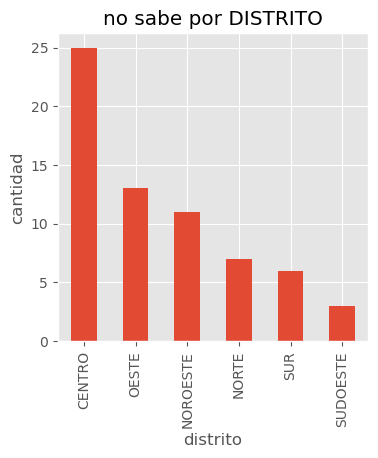

In [14]:
#NO SABE POR DISTRITO
data_distr_df[data_distr_df['intencion'] == 'NINGUNO/NOSABE']['distrito'].value_counts().plot(kind='bar', figsize=(4,4))
plt.title('no sabe por DISTRITO')
plt.ylabel('cantidad')
plt.show()

In [19]:
data_distritos.columns = [name.lower() for name in data_distritos.columns]

data_distritos.rename(columns={'int de voto x espacio' : 'intencion'}, inplace=True)
data_distritos.head()


,interview__key,metodo,coord1__latitude,coord1__longitude,edad,genero,intencion,radio,geometry,index_right,gml_id,distrito,observacio
0,56-56-25-81,F2F,-32.881458,-60.695274,56 y mas,Masculino,LIBERTARIOS,820840409,POINT (-60.69527 -32.88146),0.0,distritos_descentralizados.1,NORTE,Villa Hortencia
1,67-96-98-06,F2F,-32.882259,-60.693571,36 a 45,Masculino,OTROS,820840410,POINT (-60.69357 -32.88226),0.0,distritos_descentralizados.1,NORTE,Villa Hortencia
2,24-21-01-39,F2F,-32.884731,-60.692882,56 y mas,Femenino,OTROS,820840502,POINT (-60.69288 -32.88473),0.0,distritos_descentralizados.1,NORTE,Villa Hortencia
3,84-96-80-81,F2F,-32.884673,-60.693464,26 a 35,Masculino,LIBERTARIOS,820840502,POINT (-60.69346 -32.88467),0.0,distritos_descentralizados.1,NORTE,Villa Hortencia
4,21-29-79-64,F2F,-32.918833,-60.703628,36 a 45,Femenino,NINGUNO/NOSABE,820841013,POINT (-60.70363 -32.91883),1.0,distritos_descentralizados.2,NOROESTE,Olga y Leticia Cossettini


In [23]:
data_distritos.columns

Index(['interview__key', 'metodo', 'coord1__latitude', 'coord1__longitude',
       'edad', 'genero', 'intencion', 'radio', 'geometry', 'index_right',
       'gml_id', 'distrito', 'observacio'],
      dtype='object')

In [35]:
intencion_distrito.reset_index(inplace=True)

In [41]:
#GANADOR POR DISTRITO EN COLUMNA PRIMERO
intencion_distrito['primero'] = intencion_distrito.iloc[:, 1:8].idxmax(axis=1)
intencion_distrito.head()

intencion,distrito,FIT,FdT,JxC,LIBERTARIOS,NINGUNO/NOSABE,OTROS,PNK,total,primero
0,CENTRO,7,24,30,18,25,10,3,117,JxC
1,NOROESTE,0,11,10,6,11,4,3,45,FdT
2,NORTE,2,10,12,7,7,4,4,46,JxC
3,OESTE,1,16,13,11,13,3,6,63,FdT
4,SUDOESTE,0,9,7,6,3,6,4,35,FdT


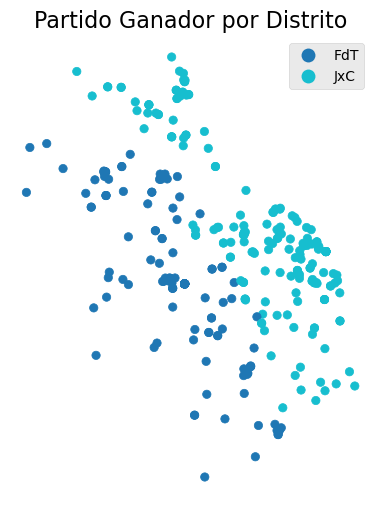

In [44]:
# 1. Unir solo la columna 'primero' de intencion_distrito al GeoDataFrame
mapa_distritos = data_distritos.merge(intencion_distrito[['distrito', 'primero']], on='distrito')

# 2. Crear el mapa coloreando por el partido ganador
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
mapa_distritos.plot(column='primero', ax=ax, legend=True, cmap='tab10')

# 3. Agregar título y ajustar diseño
plt.title("Partido Ganador por Distrito", fontsize=16)
plt.axis('off')  # Ocultar ejes
plt.show()